In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Key inputs from DCF model
years = 5
starting_sales = 31.0
capex_percent = depr_percent = 0.032
sales_growth = 0.1
ebitda_margin = 0.14
nwc_percent = 0.24
tax_rate = 0.25

In [3]:
# DCF assumptions
r = 0.12
g = 0.02

In [4]:
# For MCS model
iterations = 1000
sales_std_dev = 0.01
ebitda_std_dev = 0.02
nwc_std_dev = 0.01

In [5]:
def run_mcs():
    
    # Generate probability distributions
    sales_growth_dist = np.random.normal(loc=sales_growth, 
                                         scale=sales_std_dev, 
                                         size=(years, iterations))
    ebitda_margin_dist = np.random.normal(loc=ebitda_margin, 
                                          scale=ebitda_std_dev, 
                                          size=(years, iterations))
    nwc_percent_dist = np.random.normal(loc=nwc_percent, 
                                        scale=nwc_std_dev, 
                                        size=(years, iterations))
    
    # Calculate free cash flow
    sales_growth_dist += 1
    for i in range(1, len(sales_growth_dist)):
        sales_growth_dist[i] *= sales_growth_dist[i-1]
    sales = sales_growth_dist * starting_sales
    ebitda = sales * ebitda_margin_dist
    ebit = ebitda - (sales * depr_percent)
    tax = -(ebit * tax_rate)
    np.clip(tax, a_min=None, a_max=0)
    nwc = nwc_percent_dist * sales
    starting_nwc = starting_sales * nwc_percent
    prev_year_nwc = np.roll(nwc, 1, axis=0)
    prev_year_nwc[0] = starting_nwc
    delta_nwc = prev_year_nwc - nwc
    capex = -(sales * capex_percent)
    free_cash_flow = ebitda + tax + delta_nwc + capex
    # Discount cash flows to get DCF value
    terminal_value = free_cash_flow[-1] * (1 + g) / (r - g)
    discount_rates = [(1 / (1 + r)) ** i for i in range (1,6)]
    dcf_value = sum((free_cash_flow.T * discount_rates).T) 
    dcf_value += terminal_value * discount_rates[-1]
        
    return dcf_value

CPU times: user 40.7 ms, sys: 3.61 ms, total: 44.3 ms
Wall time: 47.1 ms


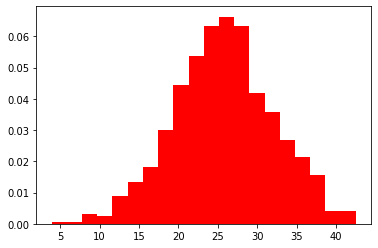

In [6]:
%time plt.hist(run_mcs(), bins=20, density=True, color="r")
plt.show()